# DETR (End-to-End Object Detection with Transformers)

## Initialization

In [1]:
# Install required libraries
!pip install -qU torch_snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 649.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 31.8 MB/s eta 0

In [2]:
# Import libraries
import os

import torch
from torch_snippets import *
from torchvision import transforms as T

from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

print(f"PyTorch Version: {torch.__version__}")
!nvidia-smi # check if GPU is available
%matplotlib inline

PyTorch Version: 2.2.1+cu121
Thu May  9 00:08:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+--------------------------------------

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda


In [4]:
# Download the dataset and a DETR repository
if not os.path.exists('open-images-bus-trucks'):
    !wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz
    !tar -xf open-images-bus-trucks.tar.xz
    !rm open-images-bus-trucks.tar.xz
    !git clone https://github.com/sizhky/detr/
%cd detr

# Move the annotated images to the correct folder
%cd ../open-images-bus-trucks/annotations
!cp mini_open_images_train_coco_format.json instances_train2017.json
!cp mini_open_images_val_coco_format.json instances_val2017.json
%cd ..
!ln -s images/ train2017
!ln -s images/ val2017
%cd ../detr

Cloning into 'detr'...
remote: Enumerating objects: 283, done.
remote: Total 283 (delta 0), reused 0 (delta 0), pack-reused 283
Receiving objects: 100% (283/283), 12.88 MiB | 26.70 MiB/s, done.
Resolving deltas: 100% (133/133), done.
/content/detr
/content/open-images-bus-trucks/annotations
/content/open-images-bus-trucks
/content/detr


In [5]:
# Define the prediction classes
CLASSES = ['', 'BUS','TRUCK']

In [6]:
# Download the pre-trained model weights and remove the class head
if not os.path.exists('detr-r50-e632da11.pth'):
    !wget https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth
    checkpoint = torch.load("detr-r50-e632da11.pth", map_location='cpu')
    del checkpoint["model"]["class_embed.weight"]
    del checkpoint["model"]["class_embed.bias"]
    torch.save(checkpoint,"detr-r50_no-class-head.pth")

--2024-05-09 00:10:45--  https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.11, 3.162.163.34, 3.162.163.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166618694 (159M) [application/octet-stream]
Saving to: ‘detr-r50-e632da11.pth’

detr-r50-e632da11.p 100%[===================>] 158.90M   146MB/s    in 1.1s    

2024-05-09 00:10:46 (146 MB/s) - ‘detr-r50-e632da11.pth’ saved [166618694/166618694]



In [7]:
# Train the model
!python main.py --coco_path ../open-images-bus-trucks/\
    --epochs 10 --lr=1e-4 --batch_size=2 --num_workers=4\
    --output_dir="outputs" --resume="detr-r50_no-class-head.pth"

Not using distributed mode
git:
  sha: 80281780ef5f1316378a5d760e78db20a72101c1, status: clean, branch: master

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=10, lr_drop=200, clip_max_norm=0.1, nclasses=2, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, dataset_file='coco', coco_path='../open-images-bus-trucks/', coco_panoptic_path=None, remove_difficult=False, output_dir='outputs', device='cuda', seed=42, resume='detr-r50_no-class-head.pth', start_epoch=0, eval=False, num_workers=4, world_size=1, dist_url='env://', distributed=False)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The paramet

In [8]:
# Load the trained model from the checkpoint
from main import get_args_parser, argparse, build_model
parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()])
args, _ = parser.parse_known_args()

model, _, _ = build_model(args)
model.load_state_dict(torch.load("outputs/checkpoint.pth")['model'])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [9]:
# Predictions post-processing

# Colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# Standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def detect(im, model, transform):
    img = transform(im).unsqueeze(0)
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'Demo model only supports images up to 1600 pixels on each side'
    outputs = model(img)

    # Keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # Convert boxes from [0, 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

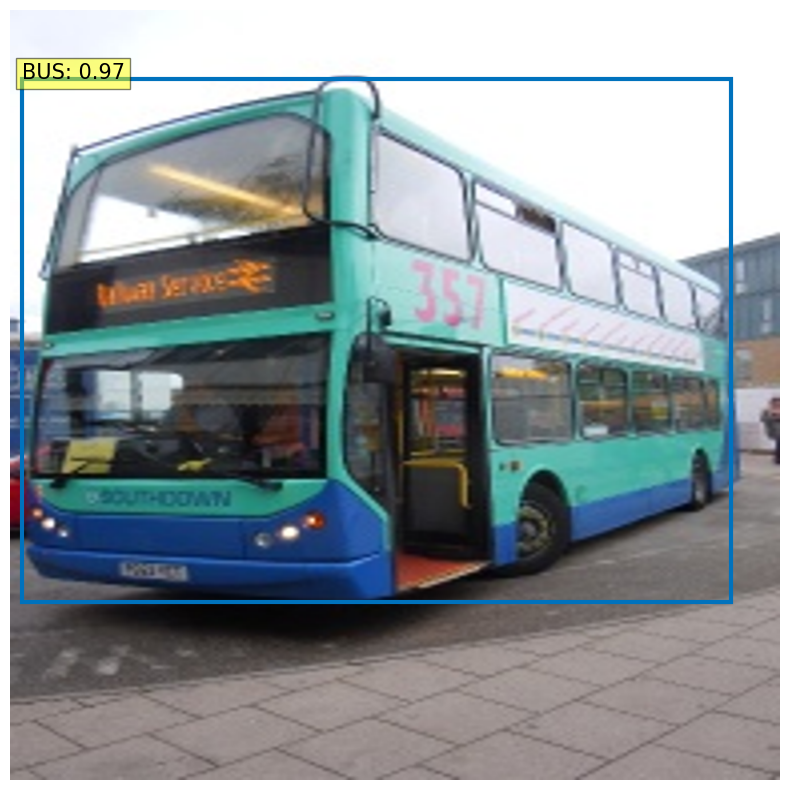

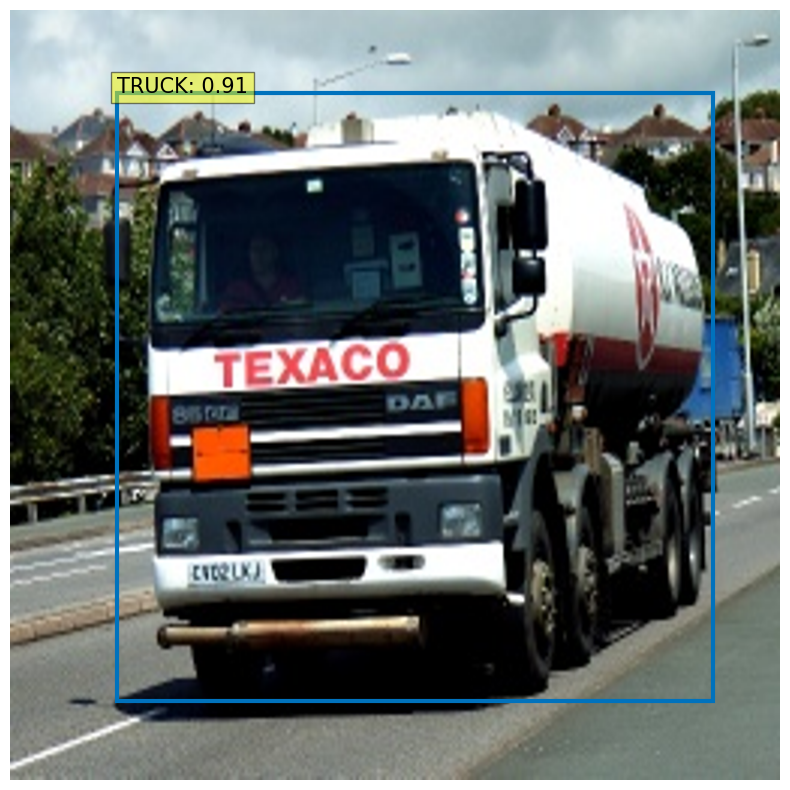

In [11]:
# Make predictions
for _ in range(2):
    image = Image.open(choose(Glob('../open-images-bus-trucks/images/*'))).resize((800, 800)).convert('RGB')
    scores, boxes = detect(image, model, transform)
    plot_results(image, scores, boxes)